# Проект. Отток клиентов оператора связи

Необходимо научиться прогнозировать отток клиентов оператора связи «Ниединогоразрыва.ком». Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. В наличии персональные данные о некоторых клиентах, информация об их тарифах и договорах.

------

## 1. Просмотр информации о данных

Импортируем необходимые модули и библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

Сохраняем данные в переменных, в качестве индексов используем *'customerID'*.

In [2]:
contract = pd.read_csv('contract.csv', index_col='customerID')
internet = pd.read_csv('internet.csv', index_col='customerID')
personal = pd.read_csv('personal.csv', index_col='customerID')
phone = pd.read_csv('phone.csv', index_col='customerID')

Посмотрим информацию о данных. Выведем примеры строк, информацию о таблицах, таблицу статистических характеристик, проверим уникальность кодов клиентов.

In [3]:
names = [contract, internet, personal, phone]
for name in names:
    print(name.head(10))
    print(name.info())
    print(name.describe())
    print('Уникальность customerID: ', name.index.is_unique, '\n\n')

             BeginDate              EndDate            Type PaperlessBilling  \
customerID                                                                     
7590-VHVEG  2020-01-01                   No  Month-to-month              Yes   
5575-GNVDE  2017-04-01                   No        One year               No   
3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month              Yes   
7795-CFOCW  2016-05-01                   No        One year               No   
9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month              Yes   
9305-CDSKC  2019-03-01  2019-11-01 00:00:00  Month-to-month              Yes   
1452-KIOVK  2018-04-01                   No  Month-to-month              Yes   
6713-OKOMC  2019-04-01                   No  Month-to-month               No   
7892-POOKP  2017-07-01  2019-11-01 00:00:00  Month-to-month              Yes   
6388-TABGU  2014-12-01                   No        One year               No   

                        PaymentMethod  

* Имеется 4 таблицы с данными. В данных нет пропусков, коды клиентов уникальны. В таблице с договорами у столбца *'TotalCharges'* необходимо поменять тип данных на вещественный.

------

## 2. Подготовка данных и обработка пропусков

Поменяет тип данных значений столбца *'TotalCharges'* на вещественный.

In [4]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

# посмотрим на получившиеся значения
contract['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

Добавим в таблице `contract` столбец *'is_gone'*, в который запишем информацию о клиентах: 1 - ушел, 0 - остался.

In [5]:
contract['is_gone'] = np.where(contract['EndDate'] == 'No', 0, 1)

Посчитаем долю ушедших клиентов.

In [6]:
number = contract[contract['is_gone'] == 1]['is_gone'].count()/len(contract)
print("Доля ушедших клиентов: {:0.1%}".format(number))

Доля ушедших клиентов: 26.5%


Заменим 1 и 0 в столбце *'SeniorCitizen'* на Yes и No соответственно. 

In [7]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({1:"Yes",0:"No"})

Объединим таблицы в один датасет.

In [8]:
data = pd.concat((contract, internet, personal, phone),axis = 1)

Переведем значения в столбцах *'BeginDate'* и *'EndDate'* в формат даты и затем вычислим продолжительность пользования услугами оператора на 01.02.2020.

In [9]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')

In [10]:
# проверим даты на адекватность
data['BeginDate'].describe()

count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: BeginDate, dtype: object

In [11]:
data['EndDate'] = data['EndDate'].replace({'No':'2020-02-01 00:00:00'})
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

In [12]:
# проверим даты на адекватность
data['EndDate'].describe()

count                    7043
unique                      5
top       2020-02-01 00:00:00
freq                     5174
first     2019-10-01 00:00:00
last      2020-02-01 00:00:00
Name: EndDate, dtype: object

Очень интересная ситуация, клиенты начали активно уходить в последние 4 месяца, а до этого никто не уходил, очень странно!

Посчитаем длительность пользования услугами оператора и запишем значения в столбец *'tenure'*.

In [13]:
data['tenure'] = (data['EndDate'].dt.year - data['BeginDate'].dt.year) * 12 + data['EndDate'].dt.month - data['BeginDate'].dt.month

Посмотрим, что получилось.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   is_gone           7043 non-null   int64         
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovie

Заменим пропуски в столбце *'MultipleLines'* на *no_line*, так как ошибок и потерь в загрузке данных нет, то пропуск, скорее всего, означает, что клиент не пользуется услугой стационарный телефон вообще.

In [15]:
data['MultipleLines'] = data['MultipleLines'].fillna('no_line')

Обратная ситуация с пропущенными значениями из таблицы `internet`, пропуски, скорее всего, означают, что клиент не пользуется услугами интернет сервиса, поэтому во всех столбцах пропуски можно заменить на значение *No*. Но также создадим в таблице `data` дополнительный признак *'no_internet_service'* - из пропущенных значений столбца *'InternetService'*. В этом столбце будут значения *Yes* и *No*, пользуется клиент услугами интернет сервиса или нет.

In [16]:
data['no_internet_service'] = np.where(data['InternetService'].isna(), 'Yes', 'No')

Далее заменим пропуски в значениях столбцов из таблицы `internet` на *No*.

In [17]:
for i in internet.columns:
    data[i] = data[i].fillna('No')

После замены типа данных в столбце *'TotalCharges'*, в таблице образовались пропуски, видимо, это новые клиенты, которые еще не внесли абонентскую плату. Так как пропусков очень мало (0.15% от датасета), то эти строки можно удалить из данных.

In [18]:
data = data.dropna()

Создадим также категориальные значения продолжительности пользования услугами оператора: *до 1 года, от 1 до 2 лет, от 2 до 3 лет, от 3 до 4 лет, от 4 до 5 лет и свыше 5 лет.*

In [19]:
# напишем функцию для категоризации
def tenure_group(data) :
    
    if data["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (data["tenure"] > 12) & (data["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (data["tenure"] > 24) & (data["tenure"] <= 36):
        return "Tenure_24-36"
    elif (data["tenure"] > 36) & (data["tenure"] <= 48):
        return "Tenure_36-48"
    elif (data["tenure"] > 48) & (data["tenure"] <= 60):
        return "Tenure_48-60"
    elif data["tenure"] > 60 :
        return "Tenure_gt_60"

Применим функцию `tenure_group` и посмотрим на получившиеся категории.

In [20]:
data['tenure_group'] = data.apply(tenure_group, axis = 1)
data['tenure_group'].value_counts()

Tenure_0-12     2175
Tenure_gt_60    1407
Tenure_12-24    1024
Tenure_48-60     832
Tenure_24-36     832
Tenure_36-48     762
Name: tenure_group, dtype: int64

В ходе исследования данных было замечено несоответствие значений столбца *'TotalCharges'* и результата умножения значений столбца *'MonthlyCharges'* на продолжительность пользования услугами. Нам интересен факт переплаты за пользование услугами.

In [21]:
# считаем значение возможной переплаты
data['overpayment'] = data['TotalCharges'] - data['MonthlyCharges'] * data['tenure']

# отрицательные значения приравниваем к 0
data.loc[data['overpayment'] < 0, 'overpayment'] = 0

# создаем дополнительный признак наличия переплаты у клиента
data['overpayment_group'] = np.where(data['overpayment'] > 0, 'Yes', 'No')

# проверим получившиеся столбцы 
print(data['overpayment'].describe(), '\n')
print(data['overpayment_group'].value_counts())

count    7032.000000
mean       22.621175
std        42.087355
min         0.000000
25%         0.000000
50%         0.000000
75%        28.700000
max       373.250000
Name: overpayment, dtype: float64 

No     3828
Yes    3204
Name: overpayment_group, dtype: int64


Посмотрим на информацию о данных после обработки пропусков и добавления новых признаков.

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   BeginDate            7032 non-null   datetime64[ns]
 1   EndDate              7032 non-null   datetime64[ns]
 2   Type                 7032 non-null   object        
 3   PaperlessBilling     7032 non-null   object        
 4   PaymentMethod        7032 non-null   object        
 5   MonthlyCharges       7032 non-null   float64       
 6   TotalCharges         7032 non-null   float64       
 7   is_gone              7032 non-null   int64         
 8   InternetService      7032 non-null   object        
 9   OnlineSecurity       7032 non-null   object        
 10  OnlineBackup         7032 non-null   object        
 11  DeviceProtection     7032 non-null   object        
 12  TechSupport          7032 non-null   object        
 13  StreamingTV          70

Данные подготовлены к дальнейшему исследованию.


-----

## 3. Исследовательский анализ данных

Построим графики соотношения категориальных признаков таблицы `data` для ушедших и оставшихся клиентов.

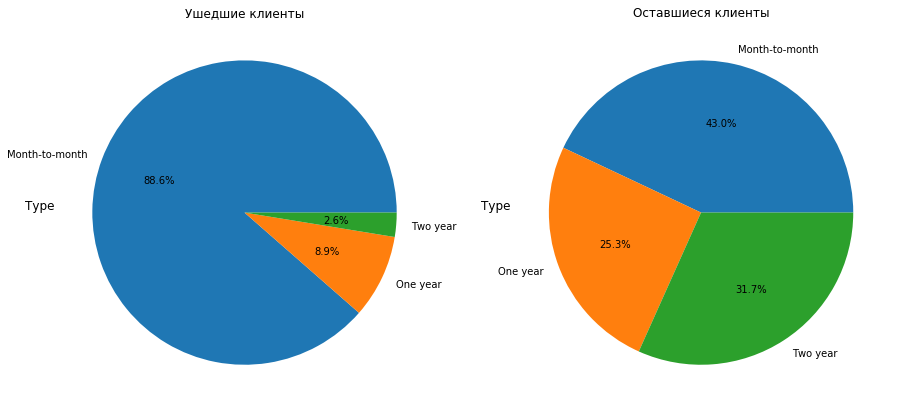

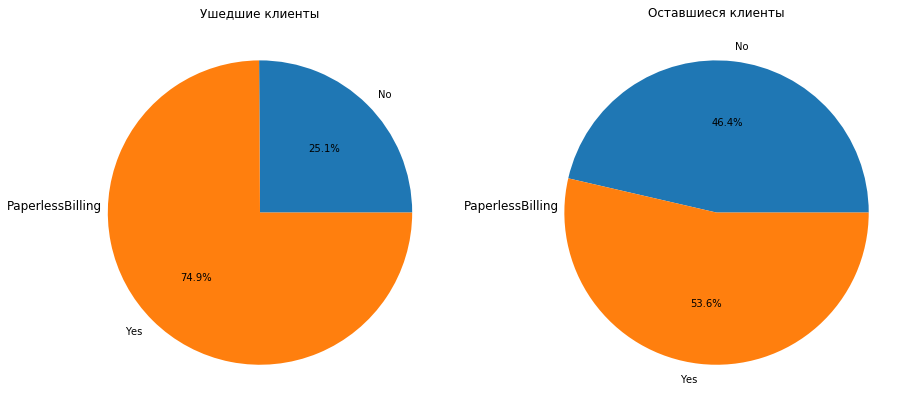

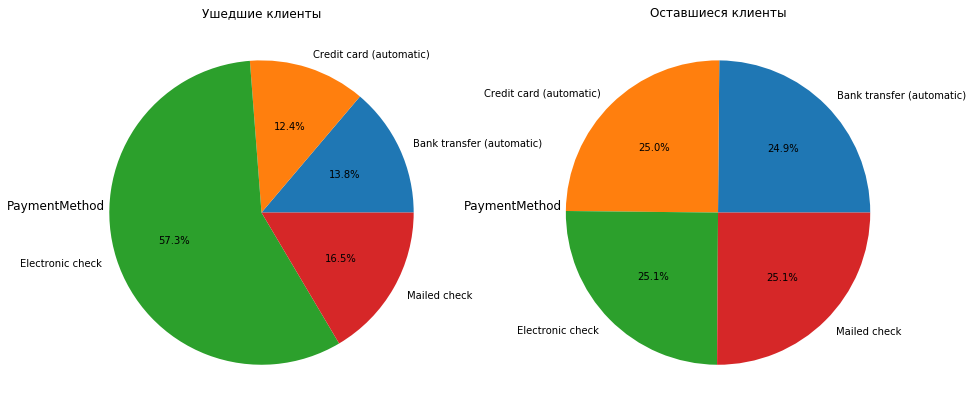

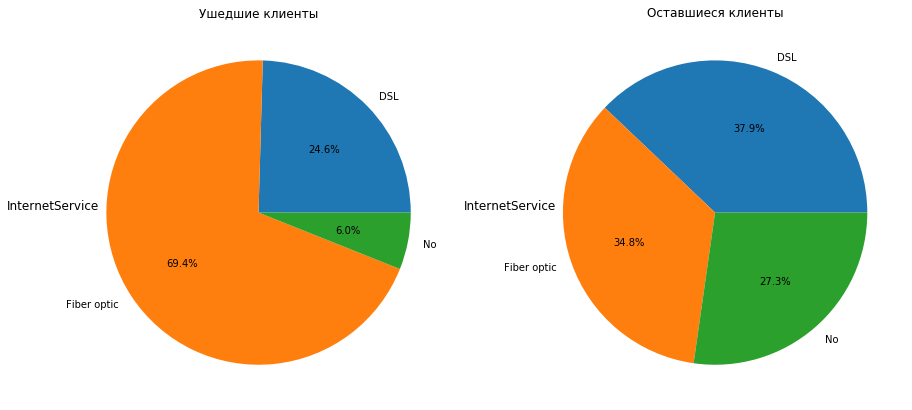

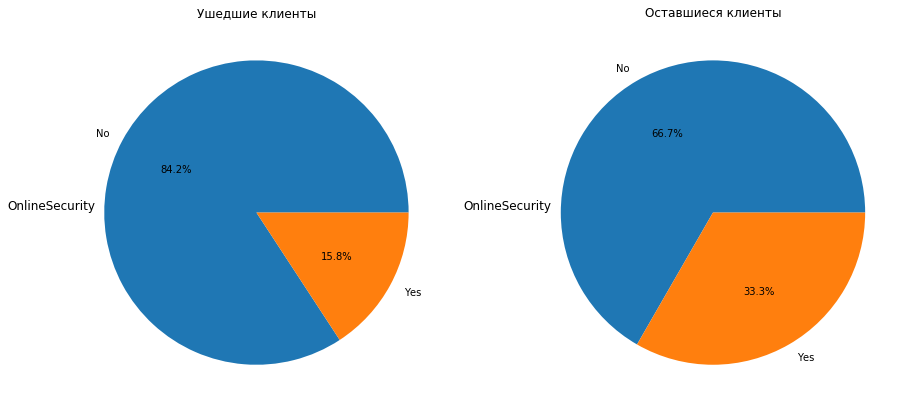

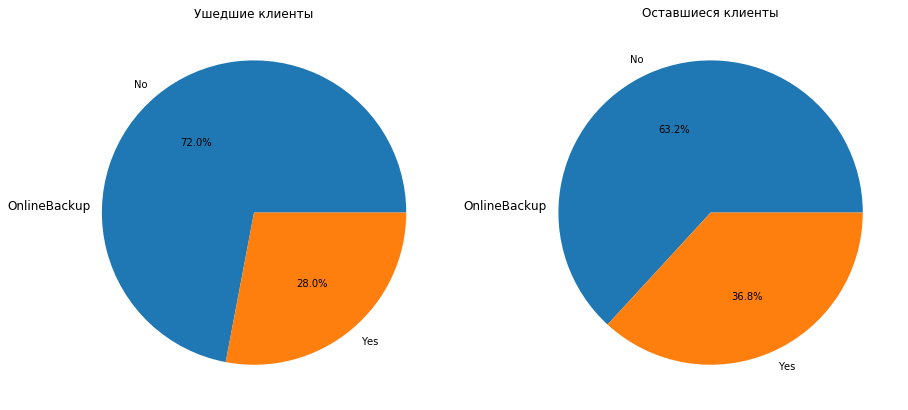

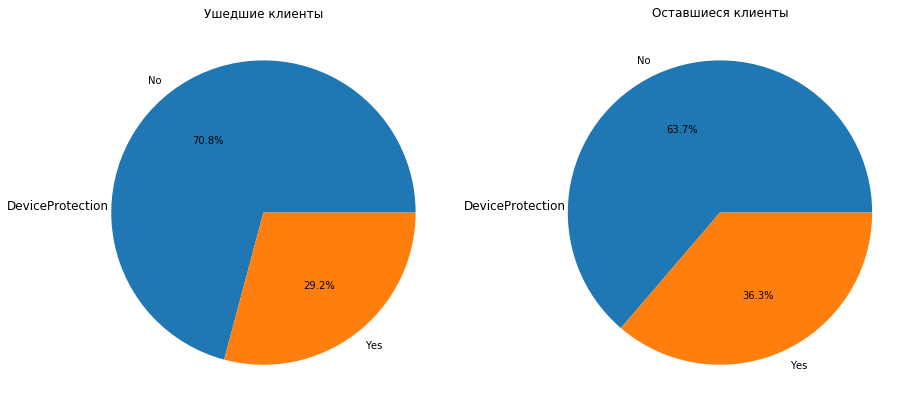

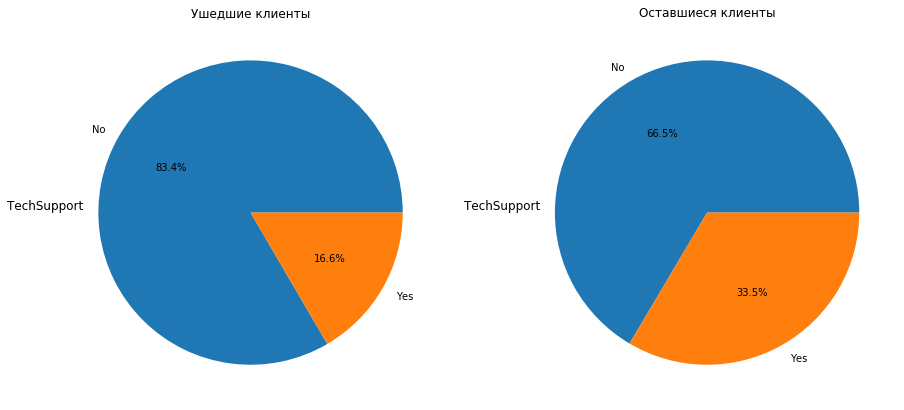

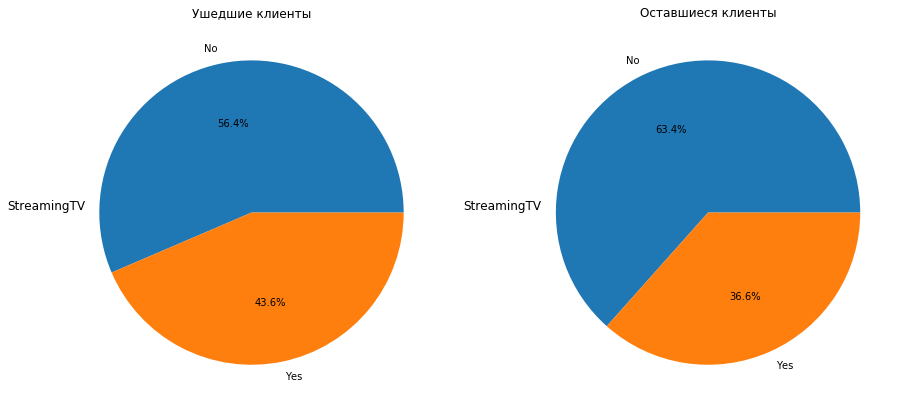

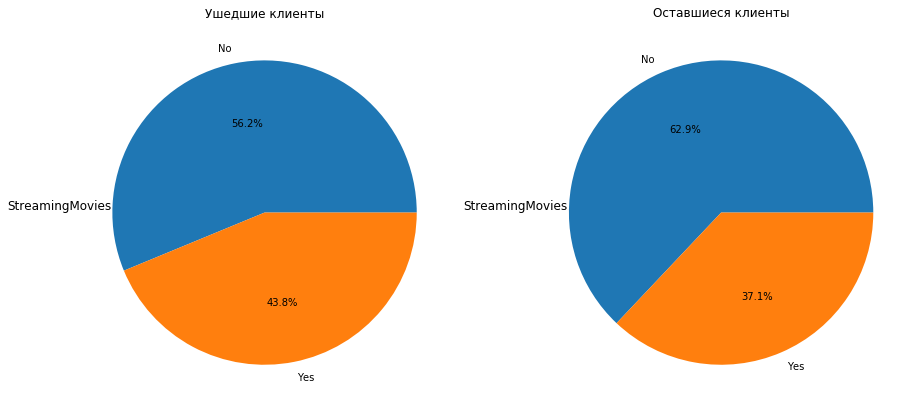

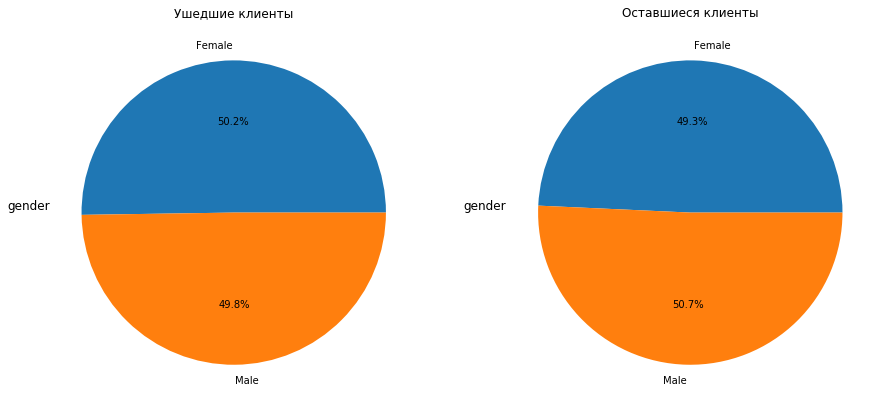

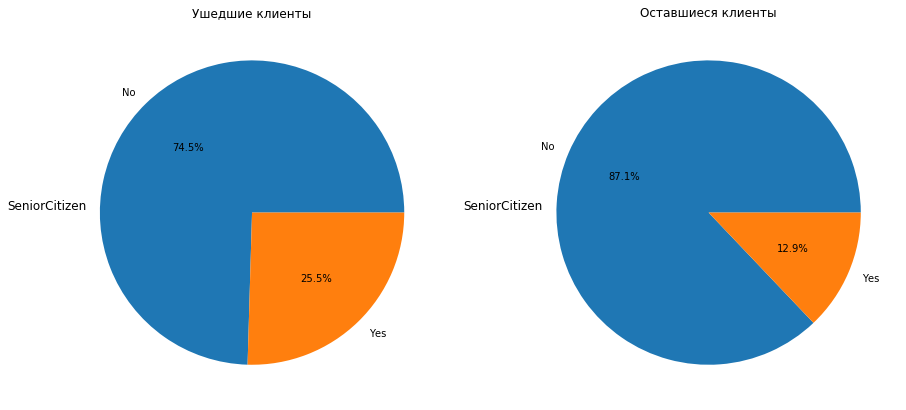

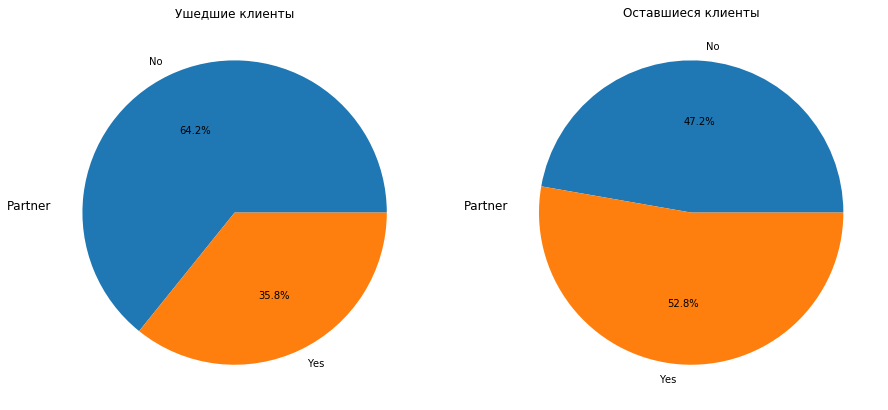

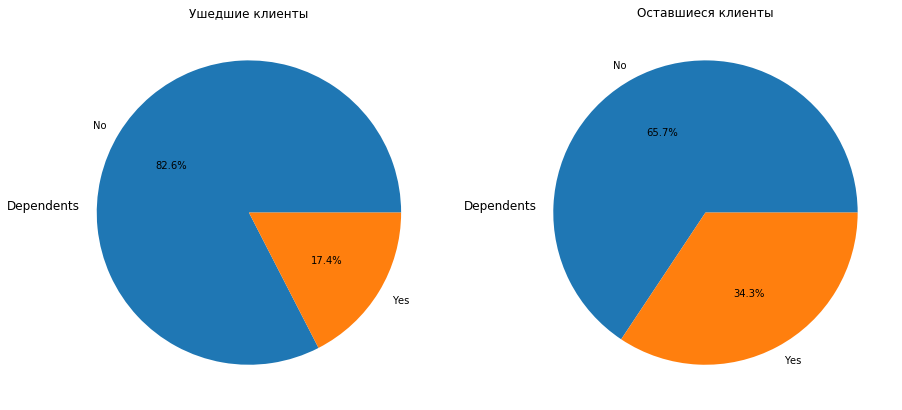

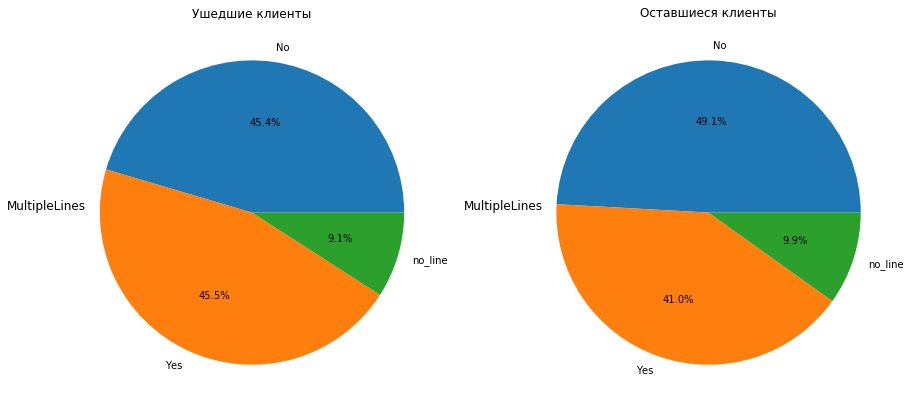

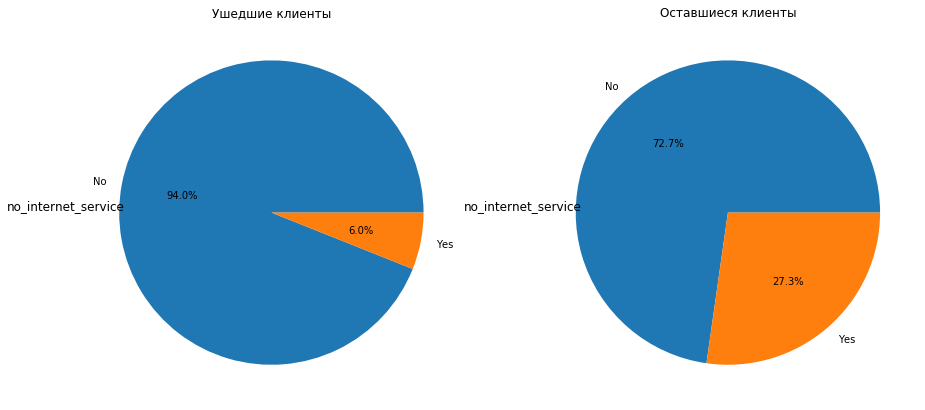

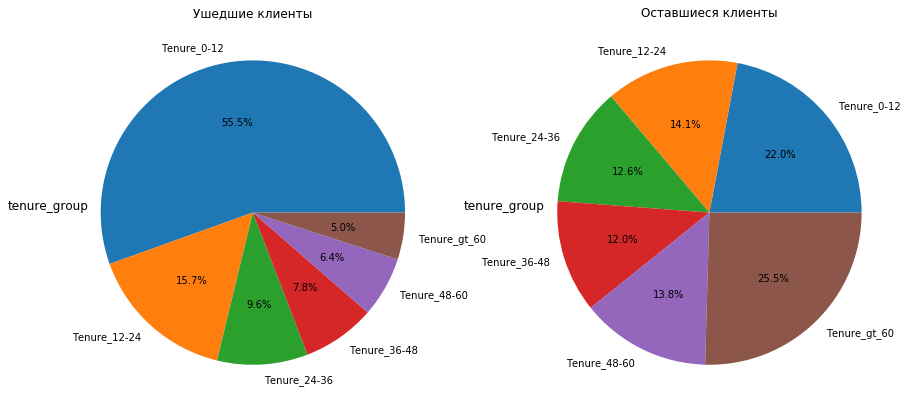

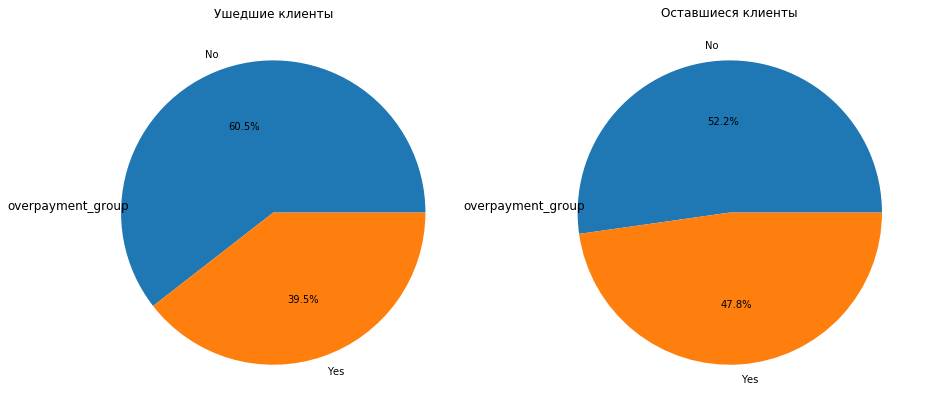

In [23]:
# столбцы, по которым не нужно строить графики
except_list = ['BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges', 'is_gone', 'tenure', 'overpayment'] 

for i in data.columns:
    if i in except_list:
        continue
    else:
        data.query('is_gone == 1').groupby(i)[i].count().plot(kind='pie', ax = plt.subplot(1,2,1), figsize=(15,8), autopct='%1.1f%%')
        plt.ylabel(i, rotation='horizontal', fontsize='large', labelpad = 15)
        plt.title('Ушедшие клиенты', fontsize='large');
        data.query('is_gone == 0').groupby(i)[i].count().plot(kind='pie', ax = plt.subplot(1,2,2), figsize=(15,8), autopct='%1.1f%%')
        plt.ylabel(i, rotation='horizontal', fontsize='large', labelpad = 15)
        plt.title('Оставшиеся клиенты', fontsize='large');
        plt.show()
print()

* Судя по графикам, подавляющее большинство ушедших клиентов имели помесячную абонентскую плату. Также ушедшие клиенты чаще пользовались PaperlessBilling  и Electronic Check, чаще использовали оптический кабель для пользования услугами.

Построим график, показывающий соотношение оставшихся и ушедших клиентов в зависимости от времени пользования услугами.

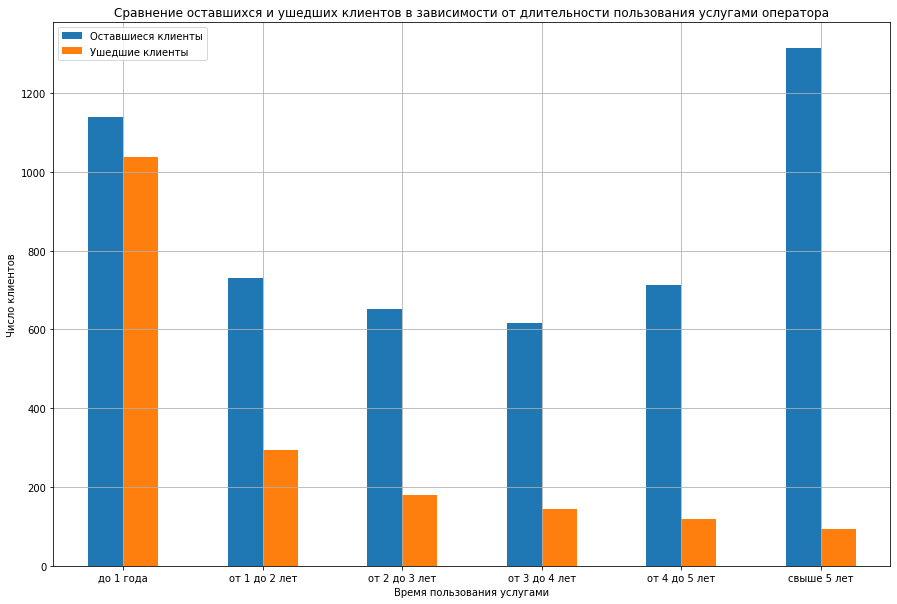

In [24]:
(data
 .pivot_table(index='tenure_group', columns='is_gone', aggfunc={'is_gone':'count'})
 .plot(kind='bar', figsize=(15,10), grid=True)
)
plt.title('Сравнение оставшихся и ушедших клиентов в зависимости от длительности пользования услугами оператора');
plt.xticks([0, 1, 2, 3, 4, 5], ['до 1 года', 'от 1 до 2 лет', 'от 2 до 3 лет', 'от 3 до 4 лет', 'от 4 до 5 лет', 'свыше 5 лет'],
           rotation='horizontal');
plt.ylabel("Число клиентов");
plt.xlabel("Время пользования услугами");
plt.legend(['Оставшиеся клиенты','Ушедшие клиенты']);

* Большая часть ушедших клиентов, пользовалась услугами оператора меньше года.

Построим графики, показывающие соотношение средней помесячной и средней общей абонентской платы оставшихся и ушедших клиентов в зависимости от времени пользования услугами оператора.

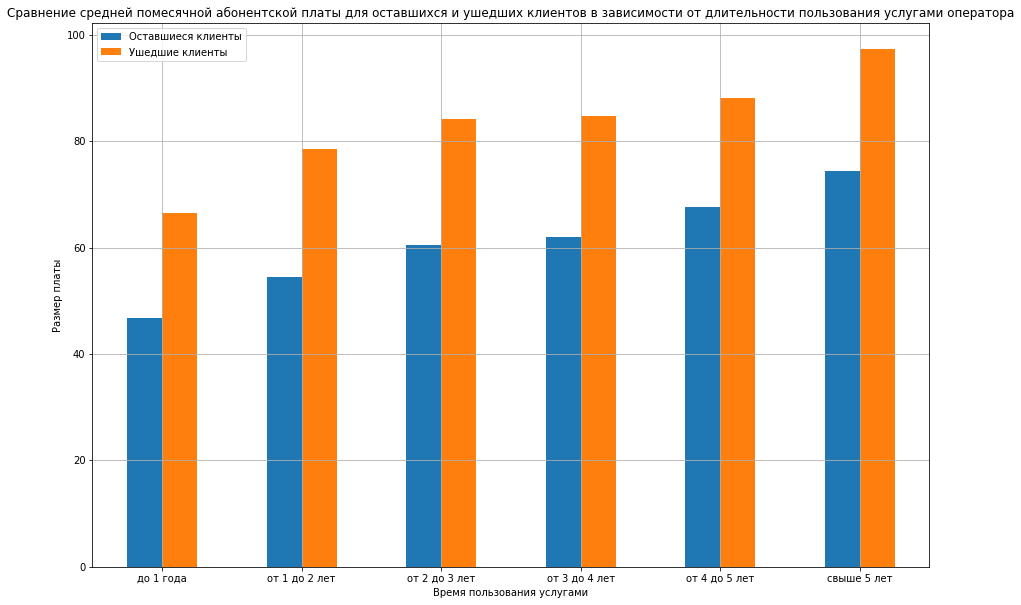

In [25]:
(data
 .pivot_table(index='tenure_group', columns='is_gone', values='MonthlyCharges', aggfunc={'MonthlyCharges':'mean'})
 .plot(kind='bar', figsize=(15,10), grid=True)
)
plt.title('Сравнение средней помесячной абонентской платы для оставшихся и ушедших клиентов в зависимости от длительности ' 
          'пользования услугами оператора');
plt.xticks([0, 1, 2, 3, 4, 5], ['до 1 года', 'от 1 до 2 лет', 'от 2 до 3 лет', 'от 3 до 4 лет', 'от 4 до 5 лет', 'свыше 5 лет'],
           rotation='horizontal');
plt.xlabel("Время пользования услугами");
plt.ylabel("Размер платы");
plt.legend(['Оставшиеся клиенты','Ушедшие клиенты']);

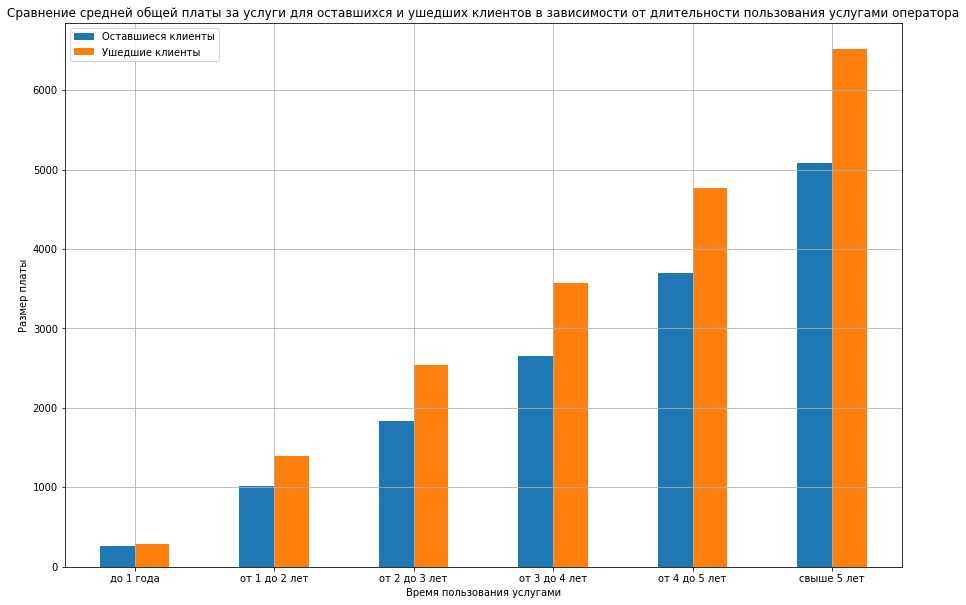

In [26]:
(data
 .pivot_table(index='tenure_group', columns='is_gone', aggfunc={'TotalCharges':'mean'})
 .plot(kind='bar', figsize=(15,10), grid=True)
)
plt.title('Сравнение средней общей платы за услуги для оставшихся и ушедших клиентов в зависимости от длительности ' 
          'пользования услугами оператора');
plt.xticks([0, 1, 2, 3, 4, 5], ['до 1 года', 'от 1 до 2 лет', 'от 2 до 3 лет', 'от 3 до 4 лет', 'от 4 до 5 лет', 'свыше 5 лет'],
           rotation='horizontal');
plt.ylabel("Размер платы");
plt.xlabel("Время пользования услугами");
plt.legend(['Оставшиеся клиенты','Ушедшие клиенты'])

* Как видно из графиков, ушедшие клиенты в среднем платили больше, чем оставшиеся.

Построим график, показывающий соотношение средней переплаты для оставшихся и ушедших клиентов, в зависимости от времения пользования услугами оператора.

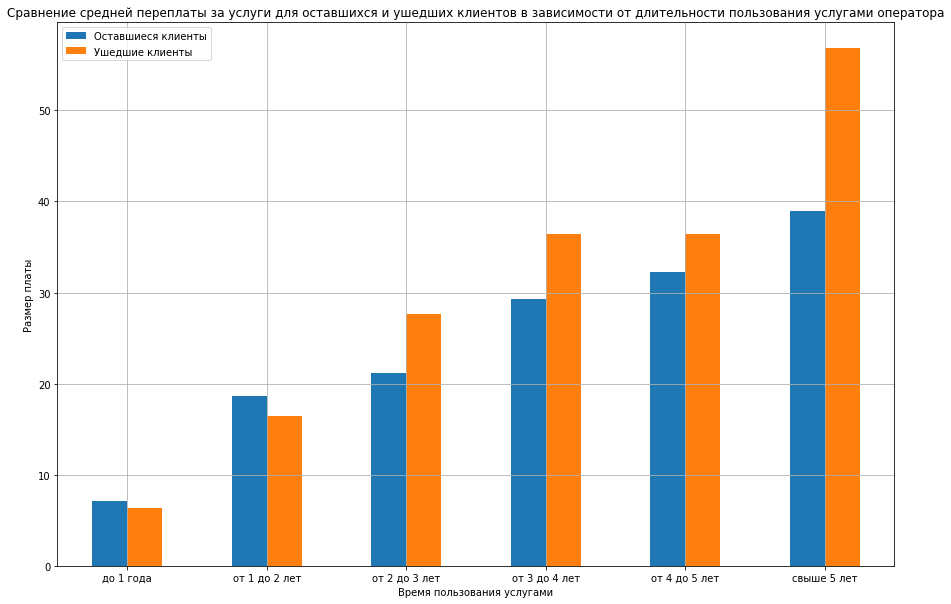

In [27]:
(data
 .pivot_table(index='tenure_group', columns='is_gone', aggfunc={'overpayment':'mean'})
 .plot(kind='bar', figsize=(15,10), grid=True)
)
plt.title('Сравнение средней переплаты за услуги для оставшихся и ушедших клиентов в зависимости от длительности ' 
          'пользования услугами оператора');
plt.xticks([0, 1, 2, 3, 4, 5], ['до 1 года', 'от 1 до 2 лет', 'от 2 до 3 лет', 'от 3 до 4 лет', 'от 4 до 5 лет', 'свыше 5 лет'],
           rotation='horizontal');
plt.ylabel("Размер платы");
plt.xlabel("Время пользования услугами");
plt.legend(['Оставшиеся клиенты','Ушедшие клиенты'])

* Начиная с периода больше 2 лет пользования услугами оператора ушедшие клиенты в среднем переплачивали больше, чем оставшиеся.

------

## 4. Подготовка данных к обучению моделей

Создадим список категориальных переменных.

In [28]:
cat_features = data.nunique()[data.nunique() < 7].keys().tolist()

# удалим из списка неиспользуемые столбцы
cat_features.remove('is_gone')
cat_features.remove('EndDate')

Проверим, что получилось.

In [29]:
cat_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'no_internet_service',
 'tenure_group',
 'overpayment_group']

Для кодирования категориальных переменных используем One-Hot Encoding.

In [30]:
data_ohe = pd.get_dummies(data=data, columns=cat_features, drop_first=True)

Посмотрим, что получилось.

In [31]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   BeginDate                              7032 non-null   datetime64[ns]
 1   EndDate                                7032 non-null   datetime64[ns]
 2   MonthlyCharges                         7032 non-null   float64       
 3   TotalCharges                           7032 non-null   float64       
 4   is_gone                                7032 non-null   int64         
 5   tenure                                 7032 non-null   int64         
 6   overpayment                            7032 non-null   float64       
 7   Type_One year                          7032 non-null   uint8         
 8   Type_Two year                          7032 non-null   uint8         
 9   PaperlessBilling_Yes                   7032 non-null 

Выделим признаки и целевой признак из датасета. Также разделим выборки на тренировочную, проверочную и тестовую в соотношении 3:1:1.

In [32]:
features = data_ohe.drop(['BeginDate', 'EndDate', 'is_gone', 'tenure'], axis=1)
target = data_ohe['is_gone']

# для сохранения баланса классов в целевом признаке используем стратификацию
features_train_val, features_test, target_train_val,  target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val, target_train_val, test_size=0.25, random_state=12345,stratify=target_train_val)

Посмотрим на размеры получившихся выборок.

In [33]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(4218, 30)
(1407, 30)
(1407, 30)


Для масштабирования численных признаков применим нормализацию.

In [34]:
# Создаем список численных признаков
numeric = ['MonthlyCharges', 'TotalCharges', 'overpayment']

transformer = Normalizer().fit(features_train[numeric])

# Приводим численные признаки выборок к одному масштабу
features_train[numeric] = transformer.transform(features_train[numeric])
features_valid[numeric] = transformer.transform(features_valid[numeric])
features_test[numeric] = transformer.transform(features_test[numeric])

/home/denis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/denis/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/denis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

Посмотрим, как выглядит тренировочная выборка.

In [35]:
features_train.head()

,MonthlyCharges,TotalCharges,overpayment,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,...,Dependents_Yes,MultipleLines_Yes,MultipleLines_no_line,no_internet_service_Yes,tenure_group_Tenure_12-24,tenure_group_Tenure_24-36,tenure_group_Tenure_36-48,tenure_group_Tenure_48-60,tenure_group_Tenure_gt_60,overpayment_group_Yes
4825-FUREZ,0.024230,0.999706,0.0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
0297-RBCSG,0.052976,0.998596,0.0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2038-OEQZH,0.268998,0.963141,0.0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2514-GINMM,0.707107,0.707107,0.0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7305-ZWMAJ,0.035236,0.999379,0.0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0


------

## 5. Обучение и сравнение моделей

Создадим пустой словарь для записи в него значений получившихся метрик и матриц ошибок исследуемых моделей.

In [36]:
dict_of_models = {}

### 5.1 LogisticRegression

In [37]:
model = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', max_iter=1000)
model.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [38]:
#pd.DataFrame(data=model.coef_, columns=features_train.columns).T.sort_values(by=0, ascending=False).plot(kind='bar', figsize=(20,10))
#plt.legend(loc='upper right')

Посчитаем метрики.

In [39]:
prob_valid = model.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
pred = model.predict(features_valid)

AUC = roc_auc_score(target_valid, prob_one_valid)
accuracy = accuracy_score(target_valid, pred)
matrix = confusion_matrix(target_valid, model.predict(features_valid))

dict_of_models['LogisticRegression'] = {'Метрика AUC-ROC': AUC,
                    'Метрика Accuracy': accuracy,
                    'Матрица ошибок': matrix}

print('Метрика AUC-ROC: {:.3f}'.format(AUC))
print('Метрика Accuracy: {:.3f}'.format(accuracy))
print('Матрица ошибок: \n{}'.format(matrix))

Метрика AUC-ROC: 0.851
Метрика Accuracy: 0.808
Матрица ошибок: 
[[939  94]
 [176 198]]


### 5.2 KNN Classifier

In [40]:
model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform').fit(features_train, target_train)

In [41]:
prob_valid = model.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
pred = model.predict(features_valid)

AUC = roc_auc_score(target_valid, prob_one_valid)
accuracy = accuracy_score(target_valid, pred)
matrix = confusion_matrix(target_valid, model.predict(features_valid))

dict_of_models['KNN Classifier'] = {'Метрика AUC-ROC': AUC,
                    'Метрика Accuracy': accuracy,
                    'Матрица ошибок': matrix}

print('Метрика AUC-ROC: {:.3f}'.format(AUC))
print('Метрика Accuracy: {:.3f}'.format(accuracy))
print('Матрица ошибок: \n{}'.format(matrix))

Метрика AUC-ROC: 0.783
Метрика Accuracy: 0.760
Матрица ошибок: 
[[869 164]
 [173 201]]


### 5.3 SVM Classifier

In [42]:
model = svm.SVC(kernel="linear", gamma='auto', random_state=12345, probability=True, C=1).fit(features_train, target_train)

In [43]:
prob_valid = model.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
pred = model.predict(features_valid)

AUC = roc_auc_score(target_valid, prob_one_valid)
accuracy = accuracy_score(target_valid, pred)
matrix = confusion_matrix(target_valid, model.predict(features_valid))

dict_of_models['SVM Classifier'] = {'Метрика AUC-ROC': AUC,
                    'Метрика Accuracy': accuracy,
                    'Матрица ошибок': matrix}

print('Метрика AUC-ROC: {:.3f}'.format(AUC))
print('Метрика Accuracy: {:.3f}'.format(accuracy))
print('Матрица ошибок: \n{}'.format(matrix))

Метрика AUC-ROC: 0.847
Метрика Accuracy: 0.800
Матрица ошибок: 
[[945  88]
 [193 181]]


### 5.4 SGDClassifier

In [44]:
model = linear_model.SGDClassifier(random_state=12345, eta0=0.001, alpha=0.001, learning_rate='adaptive',
                                  penalty='l2', loss='modified_huber').fit(features_train, target_train)

In [45]:
prob_valid = model.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
pred = model.predict(features_valid)

AUC = roc_auc_score(target_valid, prob_one_valid)
accuracy = accuracy_score(target_valid, pred)
matrix = confusion_matrix(target_valid, model.predict(features_valid))

dict_of_models['SGDClassifier'] = {'Метрика AUC-ROC': AUC,
                    'Метрика Accuracy': accuracy,
                    'Матрица ошибок': matrix}

print('Метрика AUC-ROC: {:.3f}'.format(AUC))
print('Метрика Accuracy: {:.3f}'.format(accuracy))
print('Матрица ошибок: \n{}'.format(matrix))

Метрика AUC-ROC: 0.849
Метрика Accuracy: 0.807
Матрица ошибок: 
[[944  89]
 [183 191]]


### 5.5 RandomForestClassifier

Воспользуемся подбором гиперпараметров с помощью `GridSearchCV`.

In [46]:
parameters = {'max_depth':[5, 6, 7, 8, 9], 
              'min_samples_split':[1, 2, 3], 
              'min_samples_leaf':[9, 10, 11],
             'n_estimators':[40, 50, 60, 70]}

In [47]:
model = RandomForestClassifier(random_state=12345)

In [48]:
clf = GridSearchCV(model, parameters, n_jobs=-1, scoring='roc_auc', cv=5)
clf.fit(features_train, target_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [49]:
clf.best_params_

{'max_depth': 6,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 40}

In [50]:
model = RandomForestClassifier(n_estimators=40, random_state=12345, max_depth=6, min_samples_leaf=10, min_samples_split=2)
model.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [51]:
prob_valid = model.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
pred = model.predict(features_valid)

AUC = roc_auc_score(target_valid, prob_one_valid)
accuracy = accuracy_score(target_valid, pred)
matrix = confusion_matrix(target_valid, model.predict(features_valid))

dict_of_models['RandomForestClassifier'] = {'Метрика AUC-ROC': AUC,
                    'Метрика Accuracy': accuracy,
                    'Матрица ошибок': matrix}

print('Метрика AUC-ROC: {:.3f}'.format(AUC))
print('Метрика Accuracy: {:.3f}'.format(accuracy))
print('Матрица ошибок: \n{}'.format(matrix))

Метрика AUC-ROC: 0.846
Метрика Accuracy: 0.797
Матрица ошибок: 
[[964  69]
 [216 158]]


### 5.6 Decision Tree Classifier

Подберем гиперпараметры.

In [52]:
parameters = {'max_depth':[2, 4, 6, 8, 10], 
              'min_samples_split':[1, 2, 3, 4], 
              'min_samples_leaf':[2, 3, 4, 5, 6]}

model = DecisionTreeClassifier(random_state=12345)
clf = GridSearchCV(model, parameters, n_jobs=-1, scoring='roc_auc')
clf.fit(features_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=12345,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                    

In [53]:
clf.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [54]:
model = DecisionTreeClassifier(random_state=12345, max_depth=4, min_samples_leaf=5, min_samples_split=2)
model.fit(features_train, target_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=12345, splitter='best')

In [55]:
prob_valid = model.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
pred = model.predict(features_valid)

AUC = roc_auc_score(target_valid, prob_one_valid)
accuracy = accuracy_score(target_valid, pred)
matrix = confusion_matrix(target_valid, model.predict(features_valid))

dict_of_models['DecisionTreeClassifier'] = {'Метрика AUC-ROC': AUC,
                    'Метрика Accuracy': accuracy,
                    'Матрица ошибок': matrix}

print('Метрика AUC-ROC: {:.3f}'.format(AUC))
print('Метрика Accuracy: {:.3f}'.format(accuracy))
print('Матрица ошибок: \n{}'.format(matrix))

Метрика AUC-ROC: 0.829
Метрика Accuracy: 0.793
Матрица ошибок: 
[[932 101]
 [190 184]]


### 5.7 CatBoostClassifier

Воспользуемся подбором гиперпараметров.

In [56]:
model = CatBoostClassifier(random_state=12345, custom_metric=['AUC', 'Accuracy'], task_type='CPU',
                           eval_metric='AUC')

In [57]:
grid = {'learning_rate': [0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5],
        'depth': [3, 4, 5, 6, 7],
        'n_estimators': [30, 40, 50, 60, 70, 80]}

In [58]:
grid_search_result = model.grid_search(grid,
                                       X=features_train, 
                                       y=target_train, 
                                       plot=True,
                                      verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [59]:
model = CatBoostClassifier(random_state=12345, custom_metric=['AUC', 'Accuracy'], task_type='CPU', n_estimators=30, depth=5,
                          learning_rate=0.1, loss_function='Logloss', verbose=False).fit(features_train, target_train)

In [60]:
prob_valid = model.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
pred = model.predict(features_valid)

AUC = roc_auc_score(target_valid, prob_one_valid)
accuracy = accuracy_score(target_valid, pred)
matrix = confusion_matrix(target_valid, model.predict(features_valid))

dict_of_models['CatBoostClassifier'] = {'Метрика AUC-ROC': AUC,
                    'Метрика Accuracy': accuracy,
                    'Матрица ошибок': matrix}

print('Метрика AUC-ROC: {:.3f}'.format(AUC))
print('Метрика Accuracy: {:.3f}'.format(accuracy))
print('Матрица ошибок: \n{}'.format(matrix))

Метрика AUC-ROC: 0.847
Метрика Accuracy: 0.801
Матрица ошибок: 
[[948  85]
 [195 179]]


### 5.8 LGBMClassifier

In [61]:
parameters = {'max_depth':[3, 4, 5], 
              'learning_rate':[0.04, 0.05, 0.06], 
              'min_child_samples':[5, 10, 15, 20],
             'n_estimators':[140, 160, 200]}

model = LGBMClassifier(random_state=12345)
clf = GridSearchCV(model, parameters, n_jobs=-1, scoring='roc_auc')
clf.fit(features_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=12345, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.04, 0.05, 0.06],
                         'max_

In [62]:
clf.best_params_

{'learning_rate': 0.04,
 'max_depth': 3,
 'min_child_samples': 20,
 'n_estimators': 140}

In [63]:
model = LGBMClassifier(random_state=12345, boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.04, max_depth=3, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=140,
                        n_jobs=-1, num_leaves=1000, objective='binary',
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0).fit(features_train, target_train)

In [64]:
prob_valid = model.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
pred = model.predict(features_valid)

AUC = roc_auc_score(target_valid, prob_one_valid)
accuracy = accuracy_score(target_valid, pred)
matrix = confusion_matrix(target_valid, model.predict(features_valid))

dict_of_models['LGBMClassifier'] = {'Метрика AUC-ROC': AUC,
                    'Метрика Accuracy': accuracy,
                    'Матрица ошибок': matrix}

print('Метрика AUC-ROC: {:.3f}'.format(AUC))
print('Метрика Accuracy: {:.3f}'.format(accuracy))
print('Матрица ошибок: \n{}'.format(matrix))

Метрика AUC-ROC: 0.848
Метрика Accuracy: 0.801
Матрица ошибок: 
[[946  87]
 [193 181]]


### 5.9 Сравнение получившихся результатов

Выведем на экран результаты предсказаний.

In [65]:
# создадим пустой список для сохранения информации из словарей, чтобы потом 
# отобразить результаты графически
test= []

for name, info in dict_of_models.items():
    print('\n{}'.format(name))
    for key, value in info.items():
        if key == 'Матрица ошибок':
            print('{} \n{}'.format(key, value))
        else:
            print('{} - {:.3f}'.format(key, value))
            row = [name, key, value]
            test.append(row)


LogisticRegression
Метрика AUC-ROC - 0.851
Метрика Accuracy - 0.808
Матрица ошибок 
[[939  94]
 [176 198]]

KNN Classifier
Метрика AUC-ROC - 0.783
Метрика Accuracy - 0.760
Матрица ошибок 
[[869 164]
 [173 201]]

SVM Classifier
Метрика AUC-ROC - 0.847
Метрика Accuracy - 0.800
Матрица ошибок 
[[945  88]
 [193 181]]

SGDClassifier
Метрика AUC-ROC - 0.849
Метрика Accuracy - 0.807
Матрица ошибок 
[[944  89]
 [183 191]]

RandomForestClassifier
Метрика AUC-ROC - 0.846
Метрика Accuracy - 0.797
Матрица ошибок 
[[964  69]
 [216 158]]

DecisionTreeClassifier
Метрика AUC-ROC - 0.829
Метрика Accuracy - 0.793
Матрица ошибок 
[[932 101]
 [190 184]]

CatBoostClassifier
Метрика AUC-ROC - 0.847
Метрика Accuracy - 0.801
Матрица ошибок 
[[948  85]
 [195 179]]

LGBMClassifier
Метрика AUC-ROC - 0.848
Метрика Accuracy - 0.801
Матрица ошибок 
[[946  87]
 [193 181]]


Построим столбчатый график для наглядного сравнения метрик.

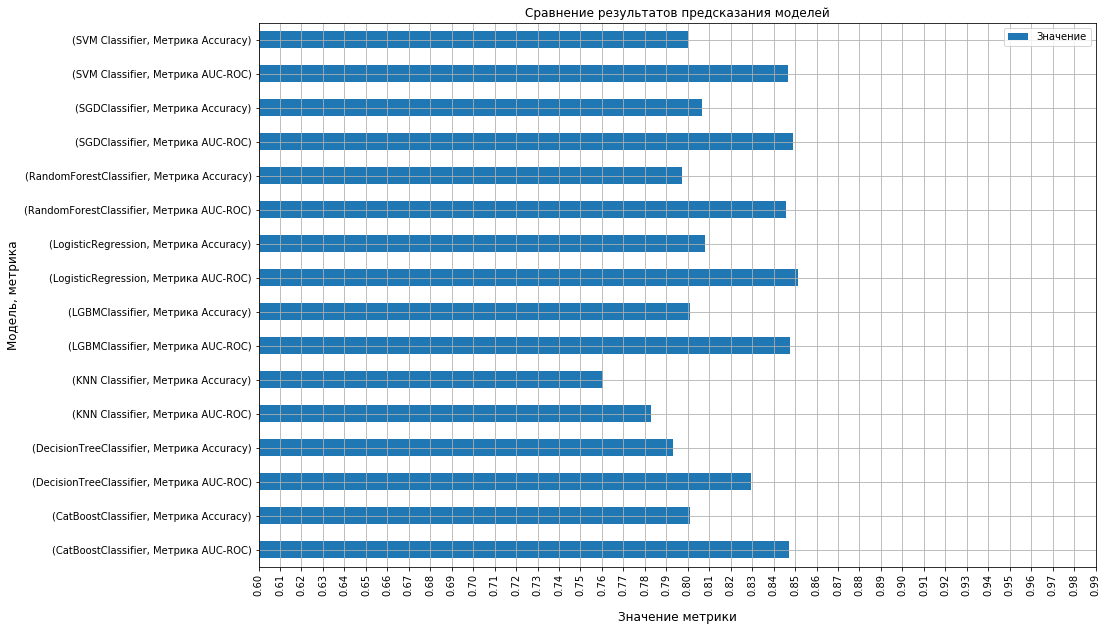

In [66]:
d = pd.DataFrame(data=test, columns=['Модель', 'Метрика', 'Значение'])
d.pivot_table(index=['Модель', 'Метрика']).plot(kind='barh', grid=True, figsize=(15,10))
plt.xlim(left=0.6)
plt.ylabel(ylabel='Модель, метрика', fontsize='large')
plt.xlabel(xlabel='Значение метрики', fontsize='large', labelpad=15)
plt.title('Сравнение результатов предсказания моделей', fontsize='large');
plt.xticks(np.arange(0.6, 1, step=0.01), rotation='vertical');

Для тестирования выбираем модель *LogisticRegression*. Она показала лучшие результаты метрик *AUC-ROC* и *Accuracy*.

------

## 6. Тестирование модели и проверка модели на адекватность.

In [67]:
model = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', max_iter=1000)
model.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [68]:
prob_valid = model.predict_proba(features_test)
prob_one_test = prob_valid[:, 1]
pred = model.predict(features_test)

AUC = roc_auc_score(target_test, prob_one_test)
accuracy = accuracy_score(target_test, pred)
matrix = confusion_matrix(target_test, model.predict(features_test))

print('Метрика AUC-ROC: {:.3f}'.format(AUC))
print('Метрика Accuracy: {:.3f}'.format(accuracy))
print('Матрица ошибок: \n{}'.format(matrix))

Метрика AUC-ROC: 0.855
Метрика Accuracy: 0.819
Матрица ошибок: 
[[944  89]
 [166 208]]


Построим ROC-кривую для наглядного сравнения результата нашей модели со случайной.

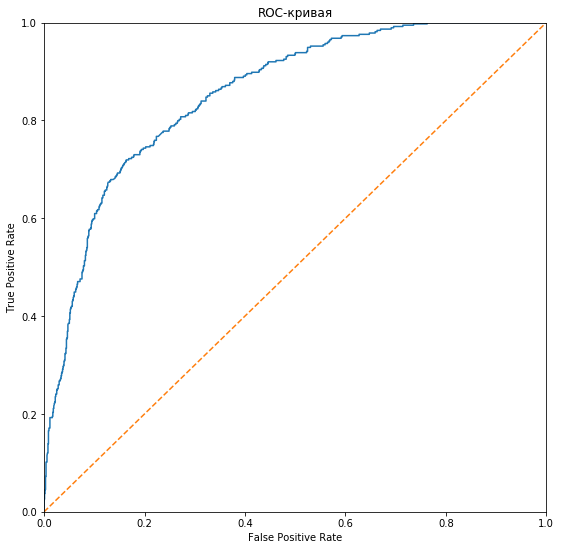

In [69]:
fpr, tpr, thresholds = roc_curve(target_test, prob_one_test)
plt.figure(figsize=(9, 9))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

Также проверим модель на адекватность по значению метрики *accuracy*. Для этого посмотрим на соотношение классов в тестовой выборке и найдем большее значение отношения всех 0 или всех 1 к общему количеству значений.

In [70]:
target_test.value_counts()

0    1033
1     374
Name: is_gone, dtype: int64

In [71]:
print('Точность случайной модели: {:.2%}'.format(target_test.value_counts()[0] / (target_test.value_counts()[0] +
                                                target_test.value_counts()[1])))

Точность случайной модели: 73.42%


Значения метрики *AUC-ROC* и метрики *Accuracy* превышают соответствующие значения случайной модели. Это говорит о высоком качестве полученной модели.

------

## 7. Выводы

В ходе проекта было необходимо построить модель для прогнозирования оттока клиентов оператора связи. Для исследования предоставлены 4 таблицы с информацией о контрактах, персональной информацией, информацией об интернет-услугах и телефонии.

На первом этапе была изучена информация о предоставленных данных. На втором этапе таблицы объединены в один датасет, добавлен целевой признак, добавлен столбец со значением продолжительности времени пользования услугами оператора, столбец с  категориальными значениями продолжительности пользования услугами оператора, столбец со значениями переплаты за пользование услугами, столбец с категориальными значениями переплаты за пользование услугами. Обработаны пропуски и выполнена подготовка данных для дальнейшего исследования.

На третьем этапе произведен исследовательский анализ данных. Построены графики соотношения категориальных признаков таблицы для ушедших и оставшихся клиентов, график, показывающий соотношение оставшихся и ушедших клиентов в зависимости от времени пользования услугами, графики, показывающие соотношение средней помесячной и средней общей абонентской платы оставшихся и ушедших клиентов в зависимости от времени пользования услугами оператора, график, показывающий соотношение средней переплаты для оставшихся и ушедших клиентов, в зависимости от времения пользования услугами оператора. Главные выводы анализа: подавляющее большинство ушедших клиентов имели помесячную абонентскую плату, ушедшие клиенты в среднем платили больше, чем оставшиеся.

На четвертом этапе данные подготовлены к обучению, осуществлено кодирование категориальных переменных, датасет разделен на тренировочную, валидационную и тестовую выборки, применена нормализация для масштабирования численных признаков.

Пятый этап посвящен обучению моделей. Были исследованы следующие модели: LogisticRegression, KNN Classifier, SVM Classifier, SGDClassifier, RandomForestClassifier, DecisionTreeClassifier, CatBoostClassifier, LGBMClassifier. Выполнено сравнение результатов обучения моделей по метрикам AUC-ROC и Accuracy. Также для каждой модели построена матрица ошибок. По результатам сравнения для тестирования была выбрана модель LogisticRegression из-за самых высоких значений метрик. Здесь стоит уточнить, что если сравнивать матрицы ошибок, то в данном случае для компании целесообразнее использовать модель RandomForestClassifier, так как количество ложноположительных предсказаний у нее меньше на 25 по сравнению с LogisticRegression. Для компании этот показатель важен, чтобы не давать скидки клиентам, которые не собираются покидать компанию.

На шестом этапе выполнено тестирование модели LogisticRegression. Получены следующие значения метрик: **AUC-ROC = 0.855**, **Accuracy = 0.819**. Выполнена успешная проверка модели на адекватность.


------